In [1]:
import pandas 
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import numpy as np

In [2]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import (Conv2D, Dense, MaxPool2D, GlobalMaxPool2D,
                                     AveragePooling2D, Input, Flatten, Dropout)
import tensorflow.keras as keras
from tensorflow import executing_eagerly
from tensorflow.compat.v1 import disable_eager_execution
# this way I do not have to reshape the data
keras.backend.set_image_data_format('channels_first')
assert keras.backend.image_data_format() == 'channels_first'

In [3]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from tensorflow.keras.utils import plot_model
# from tensorflow.keras.applications.efficientnet import EfficientNetB7, preprocess_input

In [4]:
disable_eager_execution()

In [5]:
executing_eagerly()

False

In [6]:
# Import mlcompute module to use the optional set_mlc_device API for device selection with ML Compute.
from tensorflow.python.compiler.mlcompute import mlcompute

# Select CPU device.
mlcompute.set_mlc_device(device_name='gpu') # Available options are 'cpu', 'gpu', and 'any'.

# Data Preparation

In [7]:
data_paths = ['./data.nosync/train_pos.h5', './data.nosync/train_neg.h5']

In [8]:
#     in the final run, it should be called either 'positive' or 'negative'
#     depending on which of the two classes I select
train_ar = np.vstack((np.array(h5py.File(data_paths[0])['test']),
                      np.array(h5py.File(data_paths[1])['test'])))

In [9]:
train_ar.shape

(11436, 16, 120, 120)

In [10]:
class_ar = np.append(
    np.zeros(h5py.File(data_paths[0])['test'].shape[0]) + 1,
    np.zeros(h5py.File(data_paths[1])['test'].shape[0]))

In [11]:
class_ar.shape

(11436,)

In [12]:
x_train, x_test, y_train, y_test = train_test_split(train_ar,
                                                    class_ar,
                                                    shuffle=True,
                                                    test_size=0.3)
del train_ar

# Simple CNN

In [22]:
INPUT = x_train[0,:,:,:].shape

In [23]:
INPUT

(16, 120, 120)

In [24]:
# This architecture is very similar to the
# one proposed by the researchers
model = Sequential(
    [
        Input(shape = INPUT),
        Conv2D(32, kernel_size = (10,10), activation = 'relu'),
        MaxPool2D(pool_size = (2,2)),
        Conv2D(16, kernel_size = (5,5), activation = 'relu'),
        MaxPool2D(pool_size = (2,2)),
        Conv2D(8, kernel_size = (5,5), activation = 'relu'),
        GlobalMaxPool2D(),
        Flatten(),
        Dense(50, activation = 'relu'),
        Dense(1, activation = 'sigmoid')
    ]
)



In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 111, 111)      51232     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 55, 55)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 51, 51)        12816     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 25, 25)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 21, 21)         3208      
_________________________________________________________________
global_max_pooling2d (Global (None, 8)                 0         
_________________________________________________________________
flatten (Flatten)            (None, 8)                 0

In [26]:
model.compile(loss = 'binary_crossentropy', 
              optimizer = 'adam', 
              metrics = ['accuracy'])

In [27]:
BATCH = 128
EPOCHS = 5

In [28]:
model.fit(x_train,
          y_train,
          batch_size=BATCH,
          epochs=EPOCHS,
          validation_data=(x_test, y_test))

Train on 8005 samples, validate on 3431 samples
Epoch 1/5
8005/8005 [==============================] - ETA: 0s - loss: 1.3299 - accuracy: 0.5071

/Users/leonardoalchieri/anaconda3/envs/tf_apple_2/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


8005/8005 [==============================] - 125s 16ms/sample - loss: 1.3299 - accuracy: 0.5071 - val_loss: 0.6926 - val_accuracy: 0.5235
Epoch 2/5
8005/8005 [==============================] - 121s 15ms/sample - loss: 0.6929 - accuracy: 0.5123 - val_loss: 0.6924 - val_accuracy: 0.5235
Epoch 3/5
8005/8005 [==============================] - 121s 15ms/sample - loss: 0.6929 - accuracy: 0.5123 - val_loss: 0.6923 - val_accuracy: 0.5235
Epoch 4/5
8005/8005 [==============================] - 121s 15ms/sample - loss: 0.6929 - accuracy: 0.5123 - val_loss: 0.6923 - val_accuracy: 0.5235
Epoch 5/5
8005/8005 [==============================] - 121s 15ms/sample - loss: 0.6929 - accuracy: 0.5123 - val_loss: 0.6922 - val_accuracy: 0.5235


# Pre-trained Models

In [35]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
# from tensorflow.keras.applications.efficientnet import EfficientNetB7, preprocess_input

## VGG16

In [14]:
INPUT = (3,120,120)
new_input = Input(shape=INPUT)
model = VGG16(include_top=False, input_tensor=new_input)

In [101]:
model.summary()

AttributeError: 'Tensor' object has no attribute 'summary'

**NOTA**: Le dimensioni 9:12 sono per ora le dimensioni.

In [15]:
VGG_model = VGG16(include_top=False, input_tensor=new_input)
base_model = Model(inputs = VGG_model.input, outputs = VGG_model.layers[15].output)

In [17]:
# just as a test, I shall use only the first 3 images
new_x_train = base_model.predict(preprocess_input(x = x_train[:,9:12,:,:]))
new_x_test = base_model.predict(preprocess_input(x = x_test[:,9:12,:,:]))

KeyboardInterrupt: 

In [23]:
# This architecture is very similar to the
# one proposed by the researchers
model_2 = Sequential([
    Input(shape=new_x_train[0].shape),
    Conv2D(16, kernel_size=(2, 2), activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    Flatten(),
    Dropout(0.3),
    Dense(50, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [24]:
model_2.compile(loss = 'binary_crossentropy', 
              optimizer = 'adam', 
              metrics = ['accuracy'])

In [27]:
BATCH = 128
EPOCHS = 10

In [28]:
model_2.fit(new_x_train,
            y_train,
            batch_size=BATCH,
            epochs=EPOCHS,
            validation_data=(new_x_test, y_test))

Train on 8005 samples, validate on 3431 samples
Epoch 1/10
8005/8005 [==============================] - 5s 624us/sample - loss: 0.0435 - accuracy: 0.9841 - val_loss: 0.3016 - val_accuracy: 0.9312
Epoch 2/10
8005/8005 [==============================] - 4s 520us/sample - loss: 0.0540 - accuracy: 0.9823 - val_loss: 0.2951 - val_accuracy: 0.9318
Epoch 3/10
8005/8005 [==============================] - 4s 533us/sample - loss: 0.0456 - accuracy: 0.9854 - val_loss: 0.2988 - val_accuracy: 0.9312
Epoch 4/10
8005/8005 [==============================] - 4s 552us/sample - loss: 0.0363 - accuracy: 0.9861 - val_loss: 0.3065 - val_accuracy: 0.9300
Epoch 5/10
8005/8005 [==============================] - 4s 553us/sample - loss: 0.0321 - accuracy: 0.9890 - val_loss: 0.3134 - val_accuracy: 0.9335
Epoch 6/10
8005/8005 [==============================] - 4s 542us/sample - loss: 0.0395 - accuracy: 0.9856 - val_loss: 0.2740 - val_accuracy: 0.9298
Epoch 7/10
8005/8005 [==============================] - 4s 561us

In [30]:
keras.models.save_model(model_2, 'test')

/Users/leonardoalchieri/anaconda3/envs/tf_apple_2/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.
INFO:tensorflow:Assets written to: test/assets


In [29]:
model_2.save('actually_decent_one')

/Users/leonardoalchieri/anaconda3/envs/tf_apple_2/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.
INFO:tensorflow:Assets written to: actually_decent_one/assets


In [31]:
test = keras.models.load_model('test')

## EfficientNet

In [16]:
# just as a test, I shall use only the first 3 images
x_train = preprocess_input(x = x_train[:,:3,:,:])
x_test = preprocess_input(x = x_test[:,:3,:,:])

In [17]:
INPUT = x_train[0,:,:,:].shape

In [23]:
new_input = Input(shape=INPUT)
model = EfficientNetB7(include_top=False, input_tensor=new_input)

ValueError: Operands could not be broadcast together with shapes (64, 60, 60) (64, 1, 64)

# Test

In [7]:
INPUT = (3,120,120)
new_input = Input(shape=INPUT)
VGG_model = VGG16(include_top=False, input_tensor=new_input)
base_model = Model(inputs = VGG_model.input, outputs = VGG_model.layers[15].output)

In [8]:
base_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3, 120, 120)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 120, 120)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 120, 120)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 60, 60)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 60, 60)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 60, 60)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 128, 30, 30)       0     

In [9]:
test = keras.models.load_model('main_model')

In [10]:
test.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 6, 6)          32784     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 3, 3)          0         
_________________________________________________________________
flatten (Flatten)            (None, 144)               0         
_________________________________________________________________
dropout (Dropout)            (None, 144)               0         
_________________________________________________________________
dense (Dense)                (None, 50)                7250      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 40,085
Trainable params: 40,085
Non-trainable params: 0
____________________________________________________

In [11]:
output = test(base_model.outputs)
joined_model = Model(base_model.inputs, output)

In [13]:
joined_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3, 120, 120)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 120, 120)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 120, 120)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 60, 60)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 60, 60)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 60, 60)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 128, 30, 30)       0   

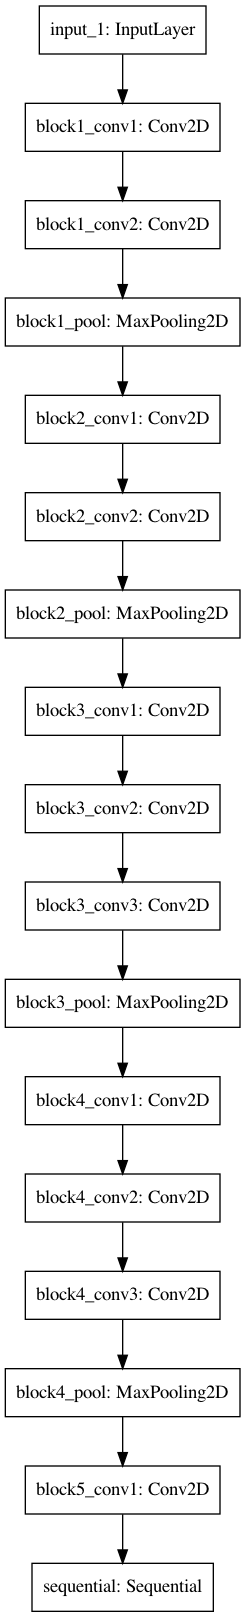

In [12]:
plot_model(joined_model)

In [27]:
!pip install graphviz

ImportError: cannot import name 'pydotprint' from 'pydot' (/Users/leonardoalchieri/anaconda3/envs/tf_apple_2/lib/python3.8/site-packages/pydot.py)